In [10]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from datetime import datetime, date, timedelta

import warnings
warnings.filterwarnings('ignore')

import FinanceDataReader as fdr

# 시각화 사용자 설정
from matplotlib import rcParams
sns.set_style('whitegrid')
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from xgboost import plot_importance as xgb_plot_importance
from lightgbm import plot_importance as lgb_plot_importance

from keras.models import load_model
import joblib
import talib

In [11]:
def magraph(df, cols, axv_list=[]) :
    rcParams['figure.figsize'] = 11.7,8.27
    plt.rc('font', family='NanumGothic')
    ax = sns.lineplot(data=df[cols])
    
    plt.title('삼성전자 이동평균선', fontsize=20)
    plt.ylabel('종가', fontsize=14)
    plt.xlabel('날짜', fontsize=14)
    plt.legend(fontsize=12, loc='best')
    
    if axv_list != [] :
        for i in axv_list :
            if len(i) == 4 :
                color = i[3]
            else :
                color = 'b'
            plt.axvline(x=datetime(i[0], i[1], i[2]), color=color, linestyle='--', linewidth=1)
    plt.show()
    return

In [12]:
def loadFeatureList(preDate) :
    # preDate 일의 데이터를 기준으로 다음 영업일의 삼성전자 변화율 예측하기
    print("*** 데이터 불러오는 중 ... ***\n")
    errMsg = "기준일에 해당하는 데이터가 없어 예측할 수 없습니다."
    samsung = fdr.DataReader('005930', preDate, preDate)
    usdkrw = fdr.DataReader('USD/KRW', preDate, preDate)
    sox = fdr.DataReader('SOXX', preDate, preDate)
    
    if any(x.empty for x in [sox, usdkrw, samsung]) :
        print(errMsg)
        return None
    
    compare_Change = pd.DataFrame(index = samsung[0:1].index)
    compare_Change['samsung'] = samsung.Change
    compare_Change['usdkrw'] = usdkrw.Change
    compare_Change['sox'] = sox.Change
    
    others = [
        ('SK하이닉스', '000660'),
        ('삼성전자우', '005935'),
        ('오리온', '271560'),
        ('DB하이텍', '000990'),
        ('메리츠증권', '008560'),
        ('넥센타이어', '002350'),
        ('대교', '019680'),
        ('인천도시가스', '034590'),
        ('미래에셋 미국 시니어론 100 ETN', '520021'),
        ('삼성 Alerian 에너지인프라 MLP ETN', '530033'),
        ('KINDEX S&P아시아TOP50', '277540'),
        ('KODEX 미국채10년선물', '308620'),
        ('미래에셋 인버스 S&P500 ETN(H)', '590011'),
        ('미래에셋 인버스 전기전자 Core5 ETN', '520005'),
        ('하나마이크론', '067310'),
        ('디바이스이엔지', '187870'),
        ('국전약품', '307750')
        ]
    for stock in others :
        el = fdr.DataReader(stock[1], preDate, preDate)
        if el.empty :
            print(errMsg)
            return None
        compare_Change[stock[0]] = el.Change
    
    return compare_Change

In [13]:
def dataToPCA(data, filePath='./') :
    try :
        n_components = 18
        columns = ['PCA_'+str(x) for x in range(0, n_components)]
        pca_fit = joblib.load(filePath + 'pca_fit_classifier.pkl')
        printcipalComponents = pca_fit.transform(data)
        principalDf = pd.DataFrame(data=printcipalComponents, columns = columns, index=data.index)
        return principalDf
    except :
        print("데이터 변환 시 문제가 발생하였습니다.")
        return None

In [14]:
def predictFromML(preDate, data, filePath='./') :
    pred_list = []
    
    model_list = [
        ('KNeighborsClassifier', "KNN 모델"),
        ('SVC', "SVM 모델"), 
        ('RandomForestClassifier', "랜덤 포레스트 모델"),
        ('GradientBoostingClassifier', "그레디언트 부스팅 모델"),
        ('XGBClassifier', "XGB 모델"),
        ('LGBMClassifier', "LGBM 모델"),
        ('VotingClassifier_hard', "Voting hard 모델"),
        ('VotingClassifier_soft', "Voting soft 모델")
    ]
    for model in model_list :
        load_model = joblib.load(filePath + model[0] + '.pkl')
        pred = load_model.predict(data)
        pred_list.append((model[0], model[1], pred))
        
    print("*** [삼성전자 주가 변화율 UP/DOWN] 머신러닝 예측결과 ***")    
    for pred in pred_list :
        isUp = "UP" if pred[2]==1 else "DOWN"
        print(f"{pred[1]} : {isUp}")
    print()
    return pred_list

In [15]:
def predictFromDL(preDate, data, filePath='./') :
    pred_list = []
    
    model_list = [
        ('Sequential', "MLP 모델"),
    ]
    for model in model_list :
        dlmodel = load_model(filePath + model[0] + '.h5')
        pred = dlmodel.predict(data)
        pred_list.append((model[0], model[1], pred))
        
    print("*** [삼성전자 주가 변화율 UP/DOWN] 딥러닝 예측결과 ***")    
    for pred in pred_list :
        isUp = "UP" if pred[2]==1 else "DOWN"
        print(f"{pred[1]} : {isUp}")
    print()
    return pred_list

In [16]:
def drawMv(preDate) :
    samsung = fdr.DataReader('005930', "2020", preDate)
    df = pd.DataFrame(index=samsung.index)
    # SMA - Simple Moving average
    df['200일선(경기선)'] = talib.SMA(samsung.Close, timeperiod=200)
    df['120일선(경기선)'] = talib.SMA(samsung.Close, timeperiod=120)
    df['60일선(수급선)'] = talib.SMA(samsung.Close, timeperiod=60)
    df['20일선(심리선)'] = talib.SMA(samsung.Close, timeperiod=20)
    df['10일선(단기매매선)'] = talib.SMA(samsung.Close, timeperiod=10)
    df['5일선(단기매매선)'] = talib.SMA(samsung.Close, timeperiod=5)
    df['종가'] = samsung.Close
    
    print("*** 초록색 선은 골든크로스(5-20), 붉은색 선은 데드크로스(5-20)를 표시합니다. ***")
    
    # 골든크로스, 데드크로스 표시하기
    tmp = df.copy()
    for i in tmp.columns :
        tmp[i+'_pred'] = tmp[i].shift(1)

    golden_5_20 = tmp[(tmp['5일선(단기매매선)'] >= tmp['20일선(심리선)']) & (tmp['5일선(단기매매선)_pred'] < tmp['20일선(심리선)_pred'])].index
    golden_5_20_index = []
    for i in golden_5_20 :
        i = i.strftime('%Y-%m-%d')
        golden_5_20_index.append((int(i[:4]), int(i[5:7]), int(i[8:]), "g"))
    
    dead_5_20 = tmp[(tmp['5일선(단기매매선)'] < tmp['20일선(심리선)']) & (tmp['5일선(단기매매선)_pred'] >= tmp['20일선(심리선)_pred'])].index
    dead_5_20_index = []
    for i in dead_5_20 :
        i = i.strftime('%Y-%m-%d')
        dead_5_20_index.append((int(i[:4]), int(i[5:7]), int(i[8:]), "r"))
    
    cross = golden_5_20_index + dead_5_20_index
    
    magraph(df, df.columns.tolist(), cross)
    
    print("! 기준일의 각 이동평균값은 다음과 같습니다. !")
    print(f"200일선(경기선) : {int(df[preDate:]['200일선(경기선)'].values[0])}")
    print(f"120일선(경기선) : {int(df[preDate:]['120일선(경기선)'].values[0])}")
    print(f"60일선(수급선) : {int(df[preDate:]['60일선(수급선)'].values[0])}")
    print(f"20일선(심리선) : {int(df[preDate:]['20일선(심리선)'].values[0])}")
    print(f"10일선(단기매매선) : {int(df[preDate:]['10일선(단기매매선)'].values[0])}")
    print(f"5일선(단기매매선) : {int(df[preDate:]['5일선(단기매매선)'].values[0])}")
    print(f"종가 : {int(df[preDate:]['종가'].values[0])}\n")
    return

In [19]:
def predict() :
    print("*** 삼성전자 주가 변화율(종가 기준) 예측 ***")
    preDate = input("기준일을 입력하세요(해당일의 다음 영업일에 대해 예측) EX) YYYY-MM-DD : \n")
    if preDate == "" :
        print("! 입력값이 없어 어제일자를 기준일로 잡습니다 !\n")
        preDate=(date.today() - timedelta(1)).isoformat()
    
    drawMv(preDate)
    
    ori_data = loadFeatureList(preDate)
    if ori_data is None :
        print("종료.")
        return
    data = dataToPCA(ori_data)
    if data is None :
        print("종료.")
        return
    print("*** 기준일 다음 영업일에 삼성전자 종가의 UP/DOWN 예측하기 *** \n")
    predictFromML(preDate, data)
    predictFromDL(preDate, data)
    return

*** 삼성전자 주가 변화율(종가 기준) 예측 ***
기준일을 입력하세요(해당일의 다음 영업일에 대해 예측) EX) YYYY-MM-DD : 
2021-02-17
*** 초록색 선은 골든크로스(5-20), 붉은색 선은 데드크로스(5-20)를 표시합니다. ***


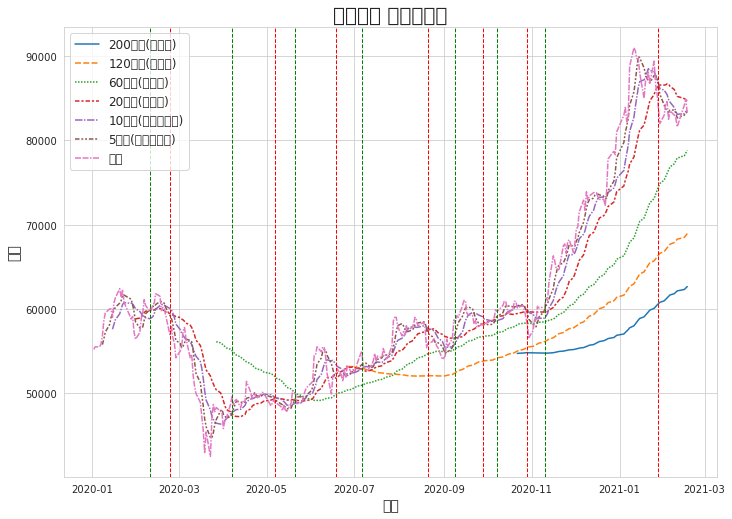

! 기준일의 각 이동평균값은 다음과 같습니다. !
200일선(경기선) : 62651
120일선(경기선) : 68943
60일선(수급선) : 78815
20일선(심리선) : 84705
10일선(단기매매선) : 83460
5일선(단기매매선) : 83320
종가 : 83200

*** 데이터 불러오는 중 ... ***

*** 기준일 다음 영업일에 삼성전자 종가의 UP/DOWN 예측하기 *** 

*** [삼성전자 주가 변화율 UP/DOWN] 머신러닝 예측결과 ***
KNN 모델 : UP
SVM 모델 : DOWN
랜덤 포레스트 모델 : DOWN
그레디언트 부스팅 모델 : DOWN
XGB 모델 : DOWN
LGBM 모델 : DOWN
Voting hard 모델 : DOWN
Voting soft 모델 : DOWN

*** [삼성전자 주가 변화율 UP/DOWN] 딥러닝 예측결과 ***
MLP 모델 : DOWN



In [25]:
#fdr.DataReader('SOXX', "2021-02-15", "2021-02-15")
predict()

In [26]:
# 확인해보기
fdr.DataReader('005930', "2021-02-03", "2021-02-18")

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-02-03,84800,85400,83400,84600,22112205,0.002370
2021-02-04,83500,83800,82100,82500,24171688,-0.024823
2021-02-05,83100,84000,82500,83500,18036835,0.012121
2021-02-08,83800,84200,83000,83000,15338765,-0.005988
2021-02-09,84000,84800,82700,82700,20898332,-0.003614
2021-02-10,82600,82600,81600,81600,23025766,-0.013301
2021-02-15,83800,84500,83300,84200,23529706,0.031863
2021-02-16,84500,86000,84200,84900,20483100,0.008314
2021-02-17,83900,84200,83000,83200,18307735,-0.020024
